# **Exploratory Data Analysis (EDA) - Malaria Detection**



**1. Deskripsi Dataset**

***Tujuan:***
Membangun sistem klasifikasi untuk mendeteksi sel darah yang terinfeksi malaria (Parasitized) atau tidak (Uninfected) berdasarkan gambar mikroskopis.

***Struktur Dataset:***
Dataset ini sudah dibagi 3:

- train/Parasitized, train/Uninfected

- valid/Parasitized, valid/Uninfected

- test/Parasitized, test/Uninfected

Dataset bersumber dari Kaggle: https://www.kaggle.com/datasets/shahriar26s/malaria-detection

Pertanyaan Kunci:
1. Apakah dataset memiliki distribusi kelas yang seimbang?
2. Apakah gambar-gambar memiliki kualitas dan ukuran yang konsisten?
3. Apakah ada data corrupt atau duplikat?
4. Apakah ada ciri visual yang terlihat berbeda antar kelas?


**2. Import Library & Setup Path**

In [24]:
from google.colab import drive
import zipfile
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import hashlib
from PIL import Image
from PIL import UnidentifiedImageError

**3. Struktur Folder Dataset**


In [25]:
#Memuat dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#Ekstrak Dataset
zip_path = "/content/drive/My Drive/Malaria Dataset.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

In [27]:
#Cek Struktur Folder untuk memastikan dataset memiliki struktur yang sesuai
base_path = '/content/Malaria Dataset'
for root, dirs, files in os.walk(base_path):
    level = root.replace(base_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:2]:
        print(f"{subindent}{f}")

Malaria Dataset/
    test/
        Parasitized/
            C80P41ThinF_IMG_20150817_111121_cell_149_png.rf.e1a3706ce3308a7aa4462b7beb2ca0d0.jpg
            C116P77ThinF_IMG_20150930_171844_cell_111_png.rf.30b2c0c35f5ce1f03913a02a1c997057.jpg
        Uninfected/
            C117P78ThinF_IMG_20150930_214511_cell_1_png.rf.a497a4ddc33e6398d3bb77d2c6851320.jpg
            C79P40ThinF_IMG_20150817_103139_cell_25_png.rf.5d31b9177859fc8a5c8e62ed1ccc4515.jpg
    train/
        Parasitized/
            C188P149ThinF_IMG_20151203_134449_cell_202_png.rf.69e79577d3431225e6d7e00fcac32f86.jpg
            C39P4thinF_original_IMG_20150622_113632_cell_21_png.rf.4e4eb4618faf8e326eaf34da1fa39f53.jpg
        Uninfected/
            C219ThinF_IMG_20151106_145856_cell_203_png.rf.047314d94dfb079bbb5d66bffeb43dde.jpg
            C138P99ThinF_IMG_20151005_171332_cell_76_png.rf.c80a2a411ca34e81dc4ae149a5d5a62e.jpg
    valid/
        Parasitized/
            C68P29N_ThinF_IMG_20150819_134504_cell_123_png.rf.4aaf

**4. Hitung Jumlah Gambar Tiap Kelas per Split**

Dataset dibagi menjadi tiga subset: train, validation, dan test.
Masing-masing memiliki dua kelas: Parasitized dan Uninfected.

Step ini dilakukan untuk mengetahui apakah data seimbang antar kelas dan subset.

In [28]:
splits = ['train', 'valid', 'test']
classes = ['Parasitized', 'Uninfected']
total_images = 0

counts = []
for split in splits:
    for cls in classes:
        folder_path = os.path.join(base_path, split, cls)
        count = len(os.listdir(folder_path))
        total_images += count
        counts.append({'Split': split, 'Kelas': cls, 'Jumlah': count})

print(f"\n Total semua gambar: {total_images}")

counts_df = pd.DataFrame(counts)
counts_df['Persentase'] = counts_df['Jumlah'] / total_images * 100
counts_df


 Total semua gambar: 15031


,Split,Kelas,Jumlah,Persentase
0,train,Parasitized,6570,43.709667
1,train,Uninfected,6582,43.789502
2,valid,Parasitized,629,4.184685
3,valid,Uninfected,624,4.151420
4,test,Parasitized,309,2.055751
5,test,Uninfected,317,2.108975


**5. Analisis Ukuran Gambar**

Tujuan: Memeriksa konsistensi ukuran gambar untuk keperluan preprocessing.

In [29]:
def get_image_shapes(folder_path, sample=100):
    shapes = []
    files = os.listdir(folder_path)[:sample]
    for file in files:
        img = Image.open(os.path.join(folder_path, file))
        shapes.append(img.size)
    return shapes

p_shapes = get_image_shapes(os.path.join(base_path, 'train', 'Parasitized'))
u_shapes = get_image_shapes(os.path.join(base_path, 'train', 'Uninfected'))

print(p_shapes[:5])
print(u_shapes[:5])

[(224, 224), (224, 224), (224, 224), (224, 224), (224, 224)]
[(224, 224), (224, 224), (224, 224), (224, 224), (224, 224)]


**Insight:** Semua gambar yang diambil secara acak dari kedua kelas memiliki ukuran yang seragam (224x224). Ini menandakan bahwa dataset telah diproses sebelumnya dan siap digunakan untuk modeling tanpa perlu resize tambahan.

**6. Cek Gambar Corrupt**

In [30]:
def check_corrupt_images(folder_path):
    corrupted = []
    for file in os.listdir(folder_path):
        try:
            img = Image.open(os.path.join(folder_path, file))
            img.verify()
        except (UnidentifiedImageError, IOError):
            corrupted.append(file)
    return corrupted

corrupted_p = check_corrupt_images(os.path.join(base_path, 'train', 'Parasitized'))
corrupted_u = check_corrupt_images(os.path.join(base_path, 'train', 'Uninfected'))
print("Gambar rusak Parasitized:", corrupted_p)
print("Gambar rusak Uninfected:", corrupted_u)

Gambar rusak Parasitized: []
Gambar rusak Uninfected: []


**Insight:** Dari output diatas dapat kita lihat bahwa dataset bebas dari gambar rusak.

**7. Cek Duplikasi Gambar**

In [31]:
# Fungsi untuk ambil semua path gambar dari folder dan subfolder
def get_all_image_paths(folder):
    paths = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                paths.append(os.path.join(root, file))
    return paths

In [32]:
# Fungsi untuk menghitung hash dari gambar (pakai MD5)
def hash_image(path):
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

In [33]:
# Fungsi untuk mencari duplikasi berdasarkan hash
def find_duplicate_hashes(image_paths):
    hash_dict = {}
    duplicates = []

    for path in image_paths:
        h = hash_image(path)
        if h in hash_dict:
            duplicates.append((path, hash_dict[h]))  # simpan pasangan duplikat
        else:
            hash_dict[h] = path
    return duplicates, hash_dict

In [34]:
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/valid"
test_dir  = "/content/dataset/test"

# Ambil semua gambar
train_imgs = get_all_image_paths(train_dir)
valid_imgs = get_all_image_paths(valid_dir)
test_imgs  = get_all_image_paths(test_dir)

# Cek duplikasi di dalam masing-masing set
train_dupes, train_hashes = find_duplicate_hashes(train_imgs)
valid_dupes, valid_hashes = find_duplicate_hashes(valid_imgs)
test_dupes,  test_hashes  = find_duplicate_hashes(test_imgs)

# Cek duplikasi antar set
dupe_train_valid = set(train_hashes.keys()) & set(valid_hashes.keys())
dupe_train_test  = set(train_hashes.keys()) & set(test_hashes.keys())
dupe_valid_test  = set(valid_hashes.keys()) & set(test_hashes.keys())

# Cetak hasil
print(f"Duplikat di dalam train: {len(train_dupes)}")
print(f"Duplikat di dalam valid: {len(valid_dupes)}")
print(f"Duplikat di dalam test: {len(test_dupes)}")

print(f"Duplikat antara train dan valid: {len(dupe_train_valid)}")
print(f"Duplikat antara train dan test: {len(dupe_train_test)}")
print(f"Duplikat antara valid dan test: {len(dupe_valid_test)}")

Duplikat di dalam train: 0
Duplikat di dalam valid: 0
Duplikat di dalam test: 0
Duplikat antara train dan valid: 0
Duplikat antara train dan test: 0
Duplikat antara valid dan test: 0


**Insight:** Dari output diatas dapat kita lihat bahwa dataset bebas dari duplikasi.

**8. Visualisasi Distribusi Gambar**

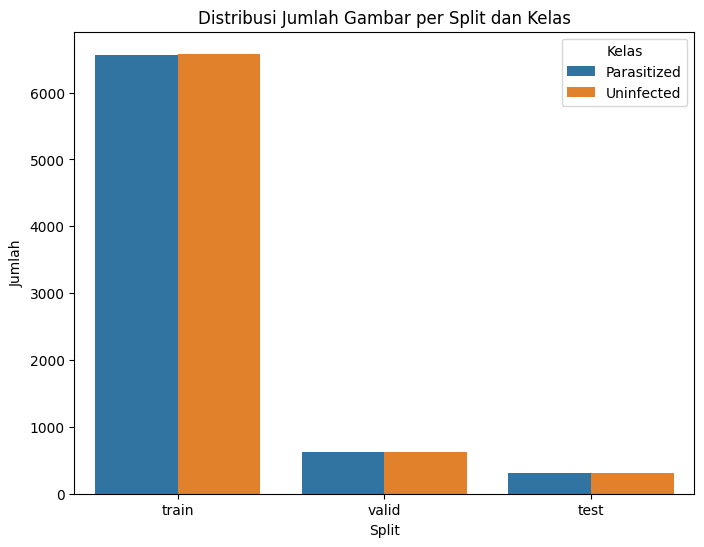

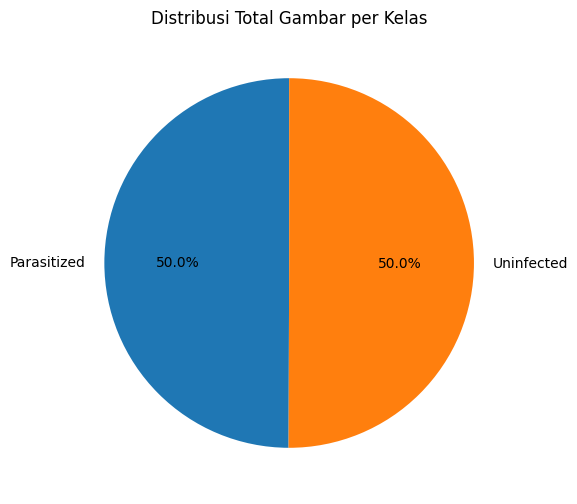

In [35]:
plt.figure(figsize=(8,6))
sns.barplot(data=counts_df, x='Split', y='Jumlah', hue='Kelas')
plt.title('Distribusi Jumlah Gambar per Split dan Kelas')
plt.show()

# Pie chart gabungan semua kelas
plt.figure(figsize=(6,6))
counts_df.groupby('Kelas')['Jumlah'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Total Gambar per Kelas')
plt.ylabel('')
plt.show()

**9. Tampilkan Contoh Gambar per Kelas**

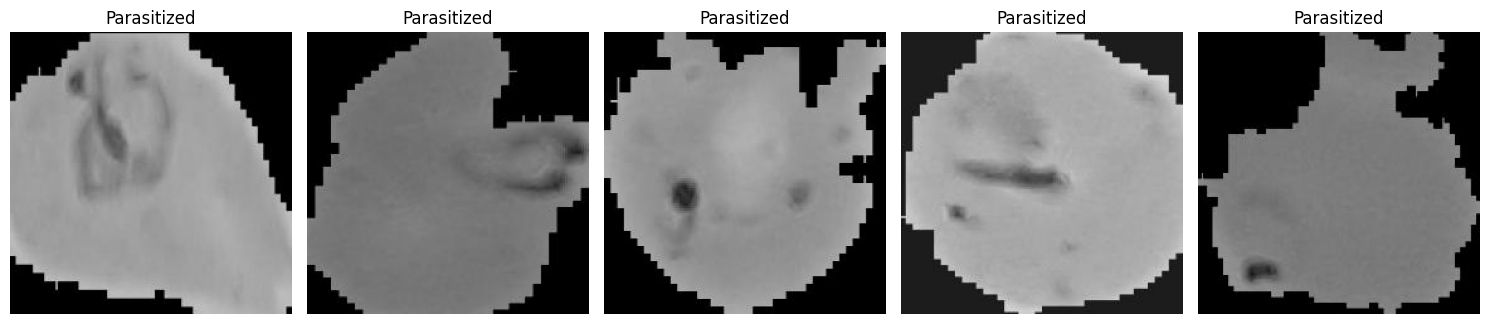

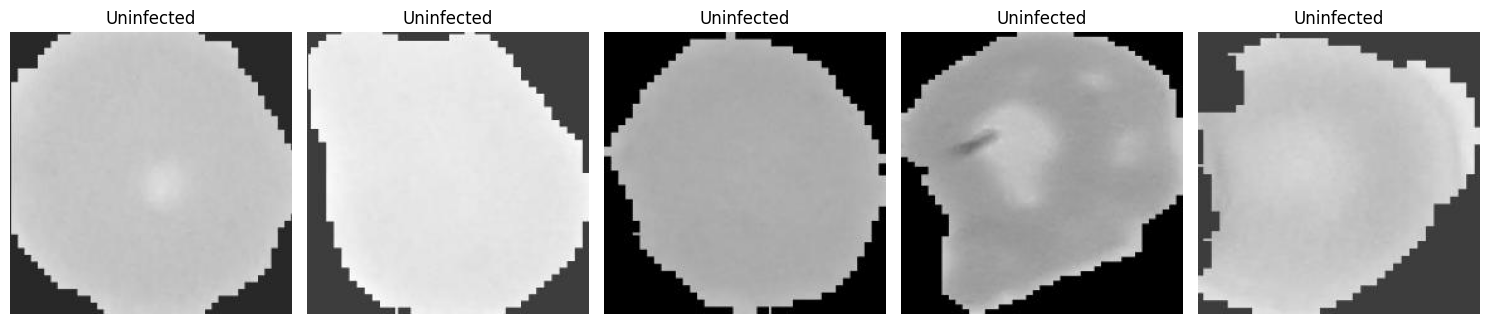

In [36]:
def plot_sample_images(folder_path, label, n=5):
    files = os.listdir(folder_path)
    sample_files = random.sample(files, n)

    plt.figure(figsize=(15, 5))
    for i, file in enumerate(sample_files):
        img = mpimg.imread(os.path.join(folder_path, file))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(os.path.join(base_path, 'train', 'Parasitized'), 'Parasitized')
plot_sample_images(os.path.join(base_path, 'train', 'Uninfected'), 'Uninfected')

**10. Ringkasan EDA**

📌 Ringkasan Insight:

1. **Distribusi kelas:** Dataset memiliki distribusi yang seimbang antara *Parasitized* dan *Uninfected* di semua split data.
2. **Ukuran gambar:** Semua gambar memiliki ukuran seragam (224x224), sehingga tidak diperlukan resize tambahan.
3. **Kualitas gambar:** Tidak ditemukan gambar corrupt dalam sampel yang diuji.
4. **Cek duplikasi:** Tidak ditemukan duplikasi gambar dalam sampel yang diuji.
3. **Perbedaan visual:** Terdapat perbedaan visual yang cukup jelas antara gambar parasitized (mengandung titik gelap) dan uninfected.

